# XAI Experiment Data Analysis

In [1]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json_normalize
import pingouin as pg
import scikit_posthocs as sp
import scipy

In [2]:
%reload_ext autoreload
%autoreload 2

## Import and preprocess data

### Read questionnaire data

In [3]:
df = pd.read_csv('data/data_cleaned.csv')

### Read news items

In [4]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [5]:
type(newsitems['xaiFeatures/presence'][1])

float

In [6]:
newsitems

,id,group,isFalsePositive,isTrueNegative,isQualification,title,subtitle,content,source,category,...,xaiFeatures/generalFactuality,xaiFeatures/generalTense,xaiFeatures/highlightedContent/text,xaiFeatures/highlightedContent/factuality,xaiFeatures/highlightedContent/tense,xaiFeatures/naturalLanguageExplanation,controlQuestion/question,controlQuestion/correctAnswer,controlQuestion/wrongAnswers/001,controlQuestion/wrongAnswers/002
0,1.0,2.0,False,False,False,Improving energy efficiency,"SDG 5 / Code 252, https://www.velatia.com/wp-c...","Despite the progress made in recent decades, <...",NaN,Electrical system manufacturers,...,high,present,There is still a long way to go on gender equa...,high,future,The text mentions SDG 5 (Gender Equality) by a...,What did Velatia complete in 2021 regarding ge...,"Velatia self-diagnosed their performance, incl...",Velatia fired 100 man to achieve gender equality.,Velatia collaborated with Google to promote ge...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,firm determination to incorporate a culture of...,high,future,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,empower its women,medium,present,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,equality plans initiated in previous years,high,past,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,include aspects such as payroll records and wo...,high,future,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,awareness-raising campaigns,medium,future,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,placing special emphasis on promoting the inco...,low,future,NaN,NaN,NaN,NaN,NaN
7,2.0,2.0,False,False,False,Improving energy efficiency,SDG 7 / code 319 / Danfoss,"To reach carbon neutrality, energy-efficient t...",NaN,Customer goods / shops,...,high,past,NaN,NaN,NaN,The text mentions SDG 7 (Affordable and Clean ...,What is a key solution mentioned in the text f...,Prioritizing electrification in the mobility s...,Focusing only on coal energy supply,Using nuclear power
8,3.0,2.0,False,False,False,Electrolux SDG Report,"SDG 7, Code : 1623",We additionally strive to contribute to other ...,Electrolux,Customer goods / shops,...,low,present,We have specific focus on gender diversity and...,medium,present,The text mentions SDG 5 (Gender Equality) by s...,Which of the following statements is true abou...,The company promotes gender diversity and work...,The company only focuses on promoting health a...,The Electrolux Food Foundation and Feed the Pl...
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Our social investment projects also often empo...,low,future,NaN,NaN,NaN,NaN,NaN


In [7]:
# only keep the relevant columns
newsitems = newsitems[["id","isFalsePositive", "isTrueNegative",
                       "title", "subtitle", "content",
                       "xaiFeatures/presence", "xaiFeatures/concreatness", "xaiFeatures/generalFactuality", "xaiFeatures/generalTense", 
                       "xaiFeatures/naturalLanguageExplanation",
                       "isQualification"]]

In [8]:
newsitems = newsitems.dropna(subset=['id'])
newsitems = newsitems[0:6]
newsitems['id'] = newsitems['id'].astype(int)
newsitems['xaiFeatures/concreatness'] = newsitems['xaiFeatures/concreatness'].astype(int)
newsitems.index = newsitems['id']

In [9]:
newsitems["contain_sdg"] =  [True, False, True, False, False, True]
newsitems["contain_sdg_pred"] = newsitems["xaiFeatures/presence"].astype(bool)

# Help

In [10]:
# underlines p-values in a dataframe that are smaller than alpha
def highlight(data, highlight_any=False, alpha=0.05):
    columns = ["p-val", "p-unc", "p-corr", "p", "pval"]

    if highlight_any:
        columns = data.columns
        
    return data.style.apply(lambda x: ["text-decoration: underline" if isinstance(v, (int, float)) and v < alpha and c in columns else "" for c, v in zip(x.index, x)], axis=1)

In [11]:
def cohen_d(d1, d2):
 # calculate the size of samples
 n1, n2 = len(d1), len(d2)
 # calculate the variance of the samples
 s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
 # calculate the pooled standard deviation
 s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
 # calculate the means of the samples
 u1, u2 = np.mean(d1), np.mean(d2)
 # calculate the effect size
 return (u1 - u2) / s

In [12]:


from itertools import combinations

def perform_kruskal_with_posthoc(df, dv, between="FEATURE", print_results=True, between_values_order=None):
    kruskal_test = pg.kruskal(df, dv=dv, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    dunn = sp.posthoc_dunn(df, val_col=dv, group_col=between, p_adjust="holm")

    values = df[between].unique() if not between_values_order else between_values_order
    pairs = list(combinations(values, 2))

    posthoc = pd.DataFrame(columns=["A", "B", "p-corr", "cohen"])

    # create a dataframe for the posthoc results
    for pair in pairs:
        posthoc = posthoc.append(
            {
                "A": pair[0],
                "B": pair[1],
                "p-corr": dunn.loc[pair[0], pair[1]],
                "cohen": cohen_d(df[df[between] == pair[0]][dv], df[df[between] == pair[1]][dv]),
            },
            ignore_index=True,
        )

    if print_results:
        print("Column name:", dv)
        print("kruskal_pval", kruskal_pval, "\n")
        print(posthoc, "\n")
        print(df.groupby(between)[dv].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[dv].describe()[["count", "mean", "std"]]



## Demographics

In [13]:
# get columns which start with "demographics"
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols
# country and nationality are not relevant and hard to use as it was an open ended question

/home/azralite/.local/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [14]:
df["demographics.age"]

0      30-39
1      21-29
2      30-39
3      50-59
4      50-59
       ...  
155    50-59
156    18-20
157    50-59
158    30-39
159    21-29
Name: demographics.age, Length: 160, dtype: object

In [15]:
# Print the age of the participants (in 100%)
df["demographics.age"].value_counts(normalize=True).sort_index() * 100

18-20           3.125
21-29          20.625
30-39          43.125
40-49          20.625
50-59          11.875
60-or-older     0.625
Name: demographics.age, dtype: float64

Text(0, 0.5, 'Number of participants')

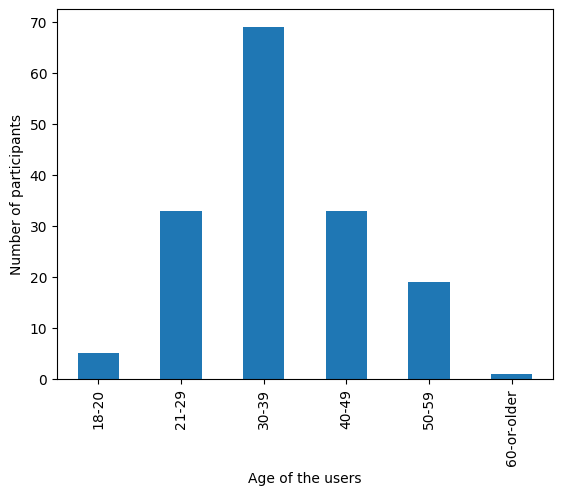

In [16]:
# Plot the users ages

ax = df["demographics.age"].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Age of the users')
ax.set_ylabel('Number of participants')

In [17]:
df["demographics.education"].value_counts(normalize=True) * 100
# university degree is the most common education level, this is surprising

university         57.500
high-school        36.250
secondary           4.375
no-degree           1.250
upper-secondary     0.625
Name: demographics.education, dtype: float64

Text(0, 0.5, 'Number of participants')

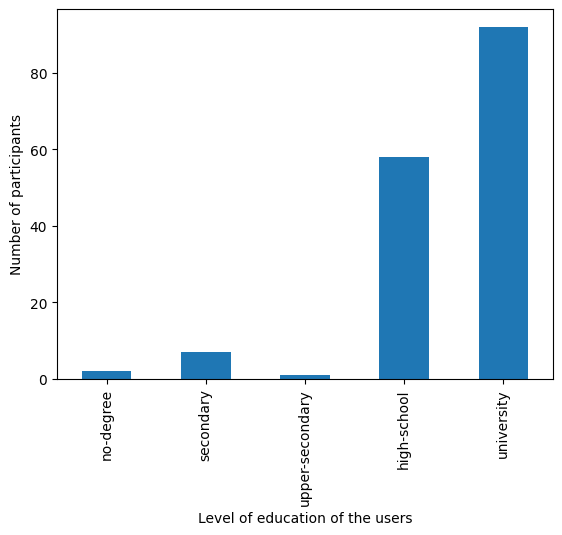

In [18]:
# Plot the users education

df_tmp = df["demographics.education"].value_counts()
df_tmp = df_tmp.iloc[[3,2,4,1,0]]
ax = df_tmp.plot(kind='bar')
ax.set_xlabel('Level of education of the users')
ax.set_ylabel('Number of participants')

In [19]:
df["demographics.employment"].value_counts(normalize=True) * 100

salaried-employee    36.875
self-employed        28.750
student              14.375
unemployed           11.250
other                 6.875
civil-servant         1.250
retiree-pensioner     0.625
Name: demographics.employment, dtype: float64

Text(0, 0.5, 'Number of participants')

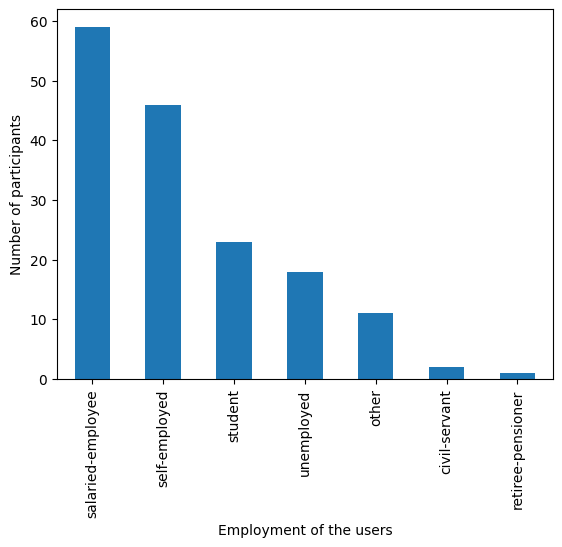

In [20]:
# Plot the users employement

ax = df["demographics.employment"].value_counts().plot(kind='bar')

ax.set_xlabel('Employment of the users')
ax.set_ylabel('Number of participants')

In [21]:
income_vc = df["demographics.income"].value_counts(normalize=True) 

print("less-than-20000-usd", income_vc["less-than-20000-usd"] * 100)
print("20000-34999-usd", income_vc["20000-34999-usd"] * 100)
print("35000-49999-usd", income_vc["35000-49999-usd"] * 100)
print("50000-74999-usd", income_vc["50000-74999-usd"] * 100)
print("75000-99999-usd", income_vc["75000-99999-usd"] * 100)
print("over-100000-usd", income_vc["over-100000-usd"] * 100)
print("no-answer", income_vc["no-answer"] * 100)

less-than-20000-usd 16.875
20000-34999-usd 20.0
35000-49999-usd 16.25
50000-74999-usd 20.0
75000-99999-usd 5.625
over-100000-usd 12.5
no-answer 8.75


Text(0, 0.5, 'Number of participants')

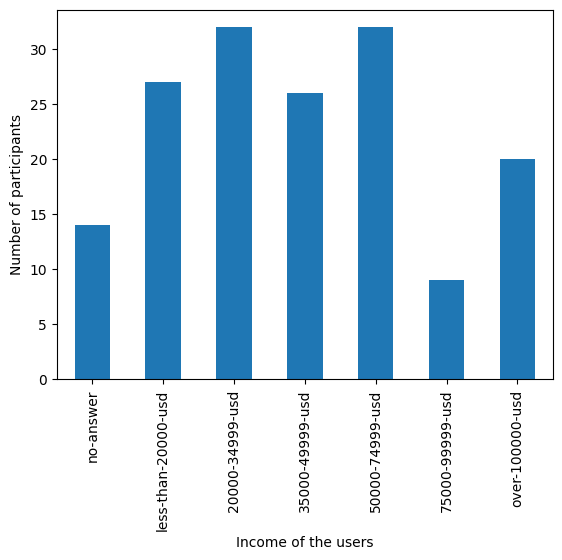

In [22]:
# Plot the users income

ax = df["demographics.income"].value_counts().iloc[[5,2,1,3,0,6,4]].plot(kind='bar')

ax.set_xlabel('Income of the users')
ax.set_ylabel('Number of participants')

In [23]:
df["demographics.gender"].value_counts(normalize=True) * 100

female     65.625
male       31.875
diverse     2.500
Name: demographics.gender, dtype: float64

Text(0, 0.5, 'Number of participants')

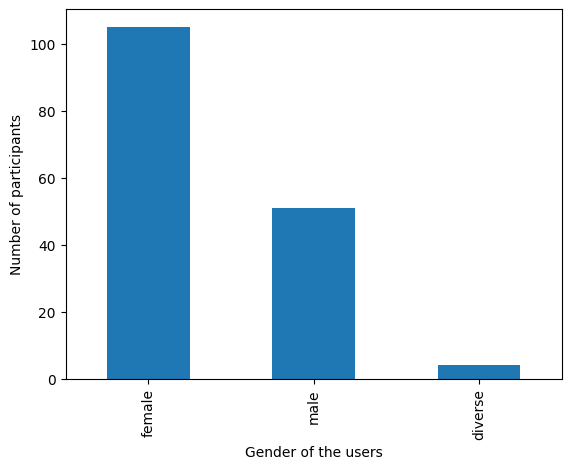

In [24]:
# Plot the users income

ax = df["demographics.gender"].value_counts().plot(kind='bar')

ax.set_xlabel('Gender of the users')
ax.set_ylabel('Number of participants')

In [25]:
demographics_table = pd.DataFrame(columns=["demographic attribute", "value", "count", "percentage"])

def add_attribute(column_name, attr_name, value_map=None):
    order = None
    if value_map is None or len(value_map) != len(df[column_name].value_counts()):
        order = df[column_name].value_counts().index
    else:
        order = value_map.keys()

    for i, value in enumerate(order):
        count = df[column_name].value_counts()[value]
        percentage = count / len(df) * 100

        if value_map is not None and value in value_map:
            value = value_map[value]

        demographics_table.loc[len(demographics_table)] = [attr_name if i == 0 else np.nan, value, count, percentage]

add_attribute("demographics.gender", "Gender", value_map={
     "female": "Female", 
     "male": "Male", 
     "diverse": "Diverse"
})
add_attribute("demographics.age", "Age", value_map={
    "18-20": "18-20",
    "21-29": "21-29",
    "30-39": "30-39",
    "40-49": "40-49",
    "50-59": "50-59",
    "60-or-older": "60 or older"
})
add_attribute("demographics.education", "Education", value_map={
    "no-degree": "No degree",
    "secondary": "Secondary/elementary school diploma",
    "upper-secondary": "Upper secondary school",
    "high-school": "High school diploma",
    "university": "University degree",
})
add_attribute("demographics.employment", "Employment", value_map={
    "apprentice": "Apprentice",
    "student": "Student",
    "salaried-employee": "Salaried employee",
    "self-employed": "Self-employed",
    "civil-servant": "Civil servant",
    "retiree-pensioner": "Retiree / pensioner",
    "unemployed": "Unemployed",
    "other": "Other",
})
add_attribute("demographics.income", "Income", value_map={
    "no-answer": "I do not want to answer",
    "less-than-20000-usd": "Less than \$20.000",
    "20000-34999-usd": "\$20.000 - \$34.999",
    "35000-49999-usd": "\$35.000 - \$49.999",
    "50000-74999-usd": "\$50.000 - \$74.999",
    "75000-99999-usd": "\$75.000 - \$99.999",
    "over-100000-usd": "Over \$100.000",
})

print(demographics_table.to_latex(index=False, escape=False, na_rep="", float_format="%.2f", longtable=True, caption="Demographic Data", label="tab:demographics"))

\begin{longtable}{llrr}
\caption{Demographic Data}
\label{tab:demographics}\\
\toprule
demographic attribute &                               value &  count &  percentage \\
\midrule
\endfirsthead
\caption[]{Demographic Data} \\
\toprule
demographic attribute &                               value &  count &  percentage \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
               Gender &                              Female &    105 &       65.62 \\
                      &                                Male &     51 &       31.87 \\
                      &                             Diverse &      4 &        2.50 \\
                  Age &                               18-20 &      5 &        3.12 \\
                      &                               21-29 &     33 &       20.62 \\
                      &                               30-39 &     69 &       43.12 \\
                      &                   

/tmp/ipykernel_6659/2229104263.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(demographics_table.to_latex(index=False, escape=False, na_rep="", float_format="%.2f", longtable=True, caption="Demographic Data", label="tab:demographics"))


# Points

In [26]:
df.groupby("FEATURE").count()["POINTS"].to_frame()

,POINTS
FEATURE,
basic,51
explanations,56
salient,53


# Time to complete the experiment

In [27]:
df["METADATA.workDurationInMinutes.qualification"] = df["METADATA.workDurationInSeconds.qualification"] / 60
df["METADATA.workDurationInMinutes.main"] = df["METADATA.workDurationInSeconds.main"] / 60
df["METADATA.workDurationInMinutes.qualification"].describe()

count    160.000000
mean      16.234583
std       11.515590
min        1.333333
25%        9.650000
50%       13.575000
75%       18.887500
max       73.700000
Name: METADATA.workDurationInMinutes.qualification, dtype: float64

In [28]:
df["METADATA.workDurationInMinutes.main"].describe()

count    160.000000
mean      21.526771
std       12.923891
min        2.966667
25%       13.625000
50%       18.850000
75%       26.141667
max       83.633333
Name: METADATA.workDurationInMinutes.main, dtype: float64

# Performance

### AI vs Human vs Human-AI

How does the AI system perform compared to humans and the combination of humans and AI? 

The task is to judge whether a report containt SDG or not, thus this is a binary classification problem. -1 = no SDG 0-100 = SDG

The metrics for the AI are calculated over the 8 news items. Metrics are calculated for each participant separately over the presented news items (e.g. a participant correctly judged 6 out of 8 news items, thus the accuracy for the participant is 6/8 = 0.75). Human-AI performance is measured after presenting the AI rating to the participants, this is also calculated for each participant separately.

#### Human vs Human-AI

We use a Wilcoxon signed-rank test to determine if there is a significant difference in participants' performance before and after seeing the AI scores (and explanations).

## Human vs AI vs Human-AI

In [29]:
from sklearn.metrics import accuracy_score,  f1_score

ai_accuracy = accuracy_score(newsitems["contain_sdg"], newsitems["contain_sdg_pred"] )
ai_f1 = f1_score(newsitems["contain_sdg"], newsitems["contain_sdg_pred"])


ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "f1": [ai_f1],
})

ai_performance_df

,accuracy,f1
0,0.666667,0.666667


In [30]:


def calculate_human_metrics(row):
    y_true = newsitems["contain_sdg"]
    y_pred_human = []
    y_pred_human_ai = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] != -1)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] != -1 )


    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.rating-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.rating-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)


    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)


    row["human_accuracy"] = human_accuracy
    row["human_f1"] = human_f1


    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_f1"] = human_ai_f1


    return row

df = df.apply(calculate_human_metrics, axis=1)



In [31]:
# show mean human scores, mean human_ai scores and ai scores in one dataframe
human_scores = df[[
    "human_accuracy", 
    "human_f1", 
]].copy()

human_ai_scores = df[[
    "human_ai_accuracy", 
    "human_ai_f1", 
]].copy()

human_scores = human_scores.rename(columns=lambda x: x.replace("human_", ""))
human_ai_scores = human_ai_scores.rename(columns=lambda x: x.replace("human_ai_", ""))

human_scores = human_scores.mean()
human_ai_scores = human_ai_scores.mean()

In [32]:


scores_df = pd.DataFrame({
  "AI": ai_performance_df.iloc[0],
  "Human (mean)": human_scores,
  "Human-AI (mean)": human_ai_scores,
})

scores_df = scores_df.rename(index={
    "accuracy": "Accuracy",
    "f1": "F1 score",
})


scores_df



,AI,Human (mean),Human-AI (mean)
Accuracy,0.666667,0.853125,0.829167
F1 score,0.666667,0.839554,0.816815


In [33]:
df["ai_accuracy"] = ai_accuracy

In [34]:


# create a new dataframe with human_accuracy, human_ai_accuracy and ai_accuracy
accuracy_df = df[["human_accuracy", "human_ai_accuracy", "ai_accuracy"]].copy()

# transform the dataframe to a long format
accuracy_df = pd.melt(
  accuracy_df.reset_index(),
  id_vars=["index"],
  value_vars=["human_accuracy", "human_ai_accuracy", "ai_accuracy"]
)

# rename the columns
accuracy_df = accuracy_df.rename(columns={
  "variable": "system",
  "value": "accuracy"
})



In [35]:


kruskal, posthoc, stats = perform_kruskal_with_posthoc(accuracy_df, 
    dv='accuracy', 
    between='system', 
    print_results=False, 
    between_values_order=["human_accuracy", "ai_accuracy", "human_ai_accuracy"])



/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(


In [36]:
def format_posthoc(pairwise, caption, label, between_col_mapping, column_a_name="System A", column_b_name="System B"):
    pairwise_latex = pairwise.copy()

    # replace "ai_accuracy" with "AI", "human_accuracy" with "Human" and "human_ai_accuracy" with "Human-AI"
    pairwise_latex["A"] = pairwise_latex["A"].apply(lambda x: between_col_mapping[x])
    pairwise_latex["B"] = pairwise_latex["B"].apply(lambda x: between_col_mapping[x])

    pairwise_latex = pairwise_latex.rename(columns={
        "A": column_a_name,
        "B": column_b_name,
        "p-corr": "$p$",
        "cohen": "Cohen's $d$"
    })

    # if p < 0.01, replace p with "<.01"
    pairwise_latex["$p$"] = pairwise_latex["$p$"].apply(lambda x: "$<.01$" if x < 0.01 else f"${x:.2f}$".replace('0.','.'))

    caption = caption + " " + "($p$-values corrected with the Holm-Bonferroni method)"

    print(pairwise_latex.to_latex(
        index=False, 
        escape=False, 
        na_rep="", 
        float_format="%.2f", 
        column_format="llrr",
        caption=caption, 
        label=f"tab:{label}"))

In [37]:
highlight(posthoc)

,A,B,p-corr,cohen
0,human_accuracy,ai_accuracy,0.000000,1.245078
1,human_accuracy,human_ai_accuracy,0.109795,0.119959
2,ai_accuracy,human_ai_accuracy,0.000000,-1.229736


In [38]:


format_posthoc(posthoc,
  caption="Pairwise comparisons of the accuracy using Dunn's tests",
  label='accuracy_pairwise',
  between_col_mapping={
    'ai_accuracy': 'AI',
    'human_accuracy': 'Human',
    'human_ai_accuracy': 'Human-AI'
  })



\begin{table}
\centering
\caption{Pairwise comparisons of the accuracy using Dunn's tests ($p$-values corrected with the Holm-Bonferroni method)}
\label{tab:accuracy_pairwise}
\begin{tabular}{llrr}
\toprule
System A & System B &    $p$ &  Cohen's $d$ \\
\midrule
   Human &       AI & $<.01$ &         1.25 \\
   Human & Human-AI &  $.11$ &         0.12 \\
      AI & Human-AI & $<.01$ &        -1.23 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_6659/2306177806.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pairwise_latex.to_latex(


In [39]:


kruskal, posthoc, stats = perform_kruskal_with_posthoc(accuracy_df, 
    dv='accuracy', 
    between='system', 
    print_results=False, 
    between_values_order=["human_accuracy", "ai_accuracy", "human_ai_accuracy"])

highlight(kruskal)

/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(


,Source,ddof1,H,p-unc
Kruskal,system,2,129.020665,0.000000


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ai_accuracy vs. human_accuracy: Custom statistical test, P_val:1.722e-25
human_accuracy vs. human_ai_accuracy: Custom statistical test, P_val:1.098e-01
ai_accuracy vs. human_ai_accuracy: Custom statistical test, P_val:7.825e-19


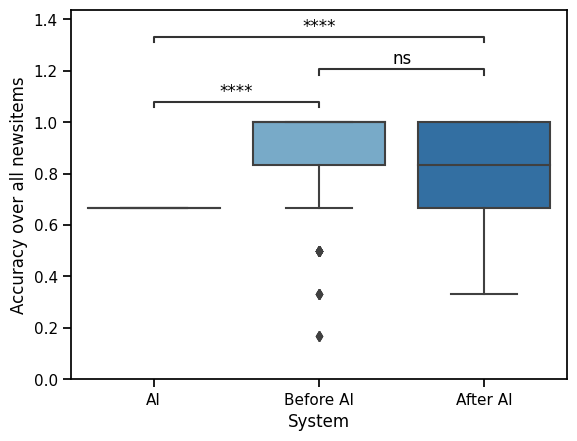

In [40]:
from itertools import combinations
from statannotations.Annotator import Annotator

values = ["ai_accuracy", "human_accuracy", "human_ai_accuracy"]
pairs = list(combinations(values, 2))

plot_params = {
  "x": "system",
  "y": "accuracy",
  "data": accuracy_df,
  "palette": "Blues",
  "order": values,
}

with sns.plotting_context('notebook'):
    ax = sns.boxplot()

    sns.boxplot(**plot_params).set(xlabel='System', ylabel='Accuracy over all newsitems')

    ax.set_ylim([0, 1])
    ax.set_xticklabels(["AI", "Before AI", "After AI"])

    p_values = []
    for pair in pairs:
        p_val = posthoc[(
            (posthoc["A"] == pair[0]) & (posthoc["B"] == pair[1]) | 
            (posthoc["B"] == pair[0]) & (posthoc["A"] == pair[1]))]["p-corr"]

        p_values.append(p_val.values[0])

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.set_pvalues_and_annotate(p_values,)

    plt.show()

In [41]:


kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_accuracy", print_results=False);

highlight(kruskal)                                                                                                                                                                                                                                                                  

/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(


,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,1.974434,0.372612


In [42]:

kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_ai_accuracy", print_results=False);

highlight(kruskal)                            

/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(
/tmp/ipykernel_6659/3294298351.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posthoc = posthoc.append(


,Source,ddof1,H,p-unc
Kruskal,FEATURE,2,3.002377,0.222865


In [43]:


wilcoxon = pg.wilcoxon(df["human_accuracy"], df["human_ai_accuracy"])
highlight(wilcoxon)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,616.000000,two-sided,0.009753,0.369176,0.555547


In [44]:
# We compare if there is a difference between before and after
# A difference would be if at one point a user said yes and at an other no

for i in range(1,7):
    df[f"newsitem.{i}.contain_before"] = df[f"newsitem.{i}.rating-before-xai"] != -1
    df[f"newsitem.{i}.contain_after"] = df[f"newsitem.{i}.rating-after-xai"] != -1

    df[f"newsitem.{i}.contain_before"] = list(map(lambda elt: -1 if elt else 1, df[f"newsitem.{i}.contain_before"] ))
    df[f"newsitem.{i}.contain_after"] = list(map(lambda elt: -1 if elt else 1, df[f"newsitem.{i}.contain_after"] ))


basic = df[df["FEATURE"] == 'basic']
salient = df[df["FEATURE"] == 'salient']
explanations = df[df["FEATURE"] == 'explanations']

for i in range(1,7):
    print(f"Question {i}")
    print(f'All users', scipy.stats.wilcoxon(df[f"newsitem.{i}.contain_before"], df[f"newsitem.{i}.contain_after"]))
    print(f'Basic', scipy.stats.wilcoxon(basic[f"newsitem.{i}.contain_before"], basic[f"newsitem.{i}.contain_after"]))
    print(f'Salient', scipy.stats.wilcoxon(salient[f"newsitem.{i}.contain_before"], salient[f"newsitem.{i}.contain_after"]))
    print(f'Explantaton', scipy.stats.wilcoxon(explanations[f"newsitem.{i}.contain_before"], explanations[f"newsitem.{i}.contain_after"]))
    print('\n')




/home/azralite/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Question 1
All users WilcoxonResult(statistic=15.0, pvalue=0.31731050786291415)
Basic WilcoxonResult(statistic=0.0, pvalue=0.31731050786291415)
Salient WilcoxonResult(statistic=2.5, pvalue=0.31731050786291415)
Explantaton WilcoxonResult(statistic=5.0, pvalue=1.0)


Question 2
All users WilcoxonResult(statistic=6.5, pvalue=0.003892417122778628)
Basic WilcoxonResult(statistic=0.0, pvalue=0.025347318677468252)
Salient WilcoxonResult(statistic=0.0, pvalue=0.025347318677468252)
Explantaton WilcoxonResult(statistic=1.5, pvalue=1.0)


Question 3
All users WilcoxonResult(statistic=28.5, pvalue=0.0046777349810472576)
Basic WilcoxonResult(statistic=0.0, pvalue=0.04550026389635839)
Salient WilcoxonResult(statistic=3.0, pvalue=0.17971249487899976)
Explantaton WilcoxonResult(statistic=10.0, pvalue=0.0955807045456294)


Question 4
All users WilcoxonResult(statistic=51.0, pvalue=0.31731050786291415)
Basic WilcoxonResult(statistic=0.0, pvalue=0.025347318677468252)
Salient WilcoxonResult(statistic=2.5,

In [45]:
for i in range(1,7):
    print(f"Question {i} : Before", scipy.stats.kruskal(basic[f"newsitem.{i}.contain_before"], salient[f"newsitem.{i}.contain_before"], explanations[f"newsitem.{i}.contain_before"]) )
    print(f"Question {i} : After", scipy.stats.kruskal(basic[f"newsitem.{i}.contain_after"], salient[f"newsitem.{i}.contain_after"], explanations[f"newsitem.{i}.contain_after"]) )
    print('\n')

Question 1 : Before KruskalResult(statistic=4.3150027134140885, pvalue=0.11561363767823152)
Question 1 : After KruskalResult(statistic=3.543865136048357, pvalue=0.17000412661439282)


Question 2 : Before KruskalResult(statistic=0.24897017630580293, pvalue=0.8829514277049061)
Question 2 : After KruskalResult(statistic=3.7111447318651796, pvalue=0.15636341996283348)


Question 3 : Before KruskalResult(statistic=0.8566573295983353, pvalue=0.6515972225316493)
Question 3 : After KruskalResult(statistic=1.968308202401597, pvalue=0.37375525237422647)


Question 4 : Before KruskalResult(statistic=1.483719090391552, pvalue=0.47622752502860166)
Question 4 : After KruskalResult(statistic=9.138727427729894, pvalue=0.010364552440976267)


Question 5 : Before KruskalResult(statistic=0.2511456936389373, pvalue=0.8819915118103282)
Question 5 : After KruskalResult(statistic=0.9277793995396689, pvalue=0.6288329110568294)


Question 6 : Before KruskalResult(statistic=2.283340890891298, pvalue=0.319285227

## Comparaison of survey post-task between groups

In [46]:
sys_eval_1 = [col for col in df.columns if col.startswith('newsitem.1.system-evaluation')]
sys_eval_2 = [col for col in df.columns if col.startswith('newsitem.2.system-evaluation')]
sys_eval_3 = [col for col in df.columns if col.startswith('newsitem.3.system-evaluation')]
sys_eval_4 = [col for col in df.columns if col.startswith('newsitem.4.system-evaluation')]
sys_eval_5 = [col for col in df.columns if col.startswith('newsitem.5.system-evaluation')]
sys_eval_6 = [col for col in df.columns if col.startswith('newsitem.6.system-evaluation')]
sys_eval_7 = [col for col in df.columns if col.startswith('newsitem.7.system-evaluation')]
sys_eval_8 = [col for col in df.columns if col.startswith('newsitem.8.system-evaluation')]

In [47]:
tst_avg1 = np.average([df[sys_eval_1[0]],df[sys_eval_2[0]],df[sys_eval_3[0]],df[sys_eval_4[0]],df[sys_eval_5[0]],df[sys_eval_6[0]]])
tst_avg1

5.428125

In [48]:
tst_avg2 = np.average([df[sys_eval_1[0]],df[sys_eval_2[0]],df[sys_eval_3[0]],df[sys_eval_4[0]]])
tst_avg3 = np.average([df[sys_eval_5[0]],df[sys_eval_6[0]]])
tst_avg2

6.2421875

In [49]:
all_true_1 = np.average([df[sys_eval_1[0]],df[sys_eval_2[0]],df[sys_eval_3[0]],df[sys_eval_4[0]]])
all_true_2 = np.average([df[sys_eval_1[1]],df[sys_eval_2[1]],df[sys_eval_3[1]],df[sys_eval_4[1]]])
all_true_3 = np.average([df[sys_eval_1[2]],df[sys_eval_2[2]],df[sys_eval_3[2]],df[sys_eval_4[2]]])
all_true_4 = np.average([df[sys_eval_1[3]],df[sys_eval_2[3]],df[sys_eval_3[3]],df[sys_eval_4[3]]])
all_true_5 = np.average([df[sys_eval_1[4]],df[sys_eval_2[4]],df[sys_eval_3[4]],df[sys_eval_4[4]]])
all_true_6 = np.average([df[sys_eval_1[5]],df[sys_eval_2[5]],df[sys_eval_3[5]],df[sys_eval_4[5]]])

basic_true_1 = np.average([basic[sys_eval_1[0]],basic[sys_eval_2[0]],basic[sys_eval_3[0]],basic[sys_eval_4[0]]])
basic_true_2 = np.average([basic[sys_eval_1[1]],basic[sys_eval_2[1]],basic[sys_eval_3[1]],basic[sys_eval_4[1]]])
basic_true_3 = np.average([basic[sys_eval_1[2]],basic[sys_eval_2[2]],basic[sys_eval_3[2]],basic[sys_eval_4[2]]])
basic_true_4 = np.average([basic[sys_eval_1[3]],basic[sys_eval_2[3]],basic[sys_eval_3[3]],basic[sys_eval_4[3]]])
basic_true_5 = np.average([basic[sys_eval_1[4]],basic[sys_eval_2[4]],basic[sys_eval_3[4]],basic[sys_eval_4[4]]])
basic_true_6 = np.average([basic[sys_eval_1[5]],basic[sys_eval_2[5]],basic[sys_eval_3[5]],basic[sys_eval_4[5]]])

salient_true_1 = np.average([salient[sys_eval_1[0]],salient[sys_eval_2[0]],salient[sys_eval_3[0]],salient[sys_eval_4[0]]])
salient_true_2 = np.average([salient[sys_eval_1[1]],salient[sys_eval_2[1]],salient[sys_eval_3[1]],salient[sys_eval_4[1]]])
salient_true_3 = np.average([salient[sys_eval_1[2]],salient[sys_eval_2[2]],salient[sys_eval_3[2]],salient[sys_eval_4[2]]])
salient_true_4 = np.average([salient[sys_eval_1[3]],salient[sys_eval_2[3]],salient[sys_eval_3[3]],salient[sys_eval_4[3]]])
salient_true_5 = np.average([salient[sys_eval_1[4]],salient[sys_eval_2[4]],salient[sys_eval_3[4]],salient[sys_eval_4[4]]])
salient_true_6 = np.average([salient[sys_eval_1[5]],salient[sys_eval_2[5]],salient[sys_eval_3[5]],salient[sys_eval_4[5]]])

exp_true_1 = np.average([explanations[sys_eval_1[0]],explanations[sys_eval_2[0]],explanations[sys_eval_3[0]],explanations[sys_eval_4[0]]])
exp_true_2 = np.average([explanations[sys_eval_1[1]],explanations[sys_eval_2[1]],explanations[sys_eval_3[1]],explanations[sys_eval_4[1]]])
exp_true_3 = np.average([explanations[sys_eval_1[2]],explanations[sys_eval_2[2]],explanations[sys_eval_3[2]],explanations[sys_eval_4[2]]])
exp_true_4 = np.average([explanations[sys_eval_1[3]],explanations[sys_eval_2[3]],explanations[sys_eval_3[3]],explanations[sys_eval_4[3]]])
exp_true_5 = np.average([explanations[sys_eval_1[4]],explanations[sys_eval_2[4]],explanations[sys_eval_3[4]],explanations[sys_eval_4[4]]])
exp_true_6 = np.average([explanations[sys_eval_1[5]],explanations[sys_eval_2[5]],explanations[sys_eval_3[5]],explanations[sys_eval_4[5]]])

In [50]:
all_false_1 = np.average([df[sys_eval_5[0]],df[sys_eval_6[0]]])
all_false_2 = np.average([df[sys_eval_5[1]],df[sys_eval_6[1]]])
all_false_3 = np.average([df[sys_eval_5[2]],df[sys_eval_6[2]]])
all_false_4 = np.average([df[sys_eval_5[3]],df[sys_eval_6[3]]])
all_false_5 = np.average([df[sys_eval_5[4]],df[sys_eval_6[4]]])
all_false_6 = np.average([df[sys_eval_5[5]],df[sys_eval_6[5]]])

basic_false_1 = np.average([basic[sys_eval_5[0]],basic[sys_eval_6[0]]])
basic_false_2 = np.average([basic[sys_eval_5[1]],basic[sys_eval_6[1]]])
basic_false_3 = np.average([basic[sys_eval_5[2]],basic[sys_eval_6[2]]])
basic_false_4 = np.average([basic[sys_eval_5[3]],basic[sys_eval_6[3]]])
basic_false_5 = np.average([basic[sys_eval_5[4]],basic[sys_eval_6[4]]])
basic_false_6 = np.average([basic[sys_eval_5[5]],basic[sys_eval_6[5]]])

salient_false_1 = np.average([salient[sys_eval_5[0]],salient[sys_eval_6[0]]])
salient_false_2 = np.average([salient[sys_eval_5[1]],salient[sys_eval_6[1]]])
salient_false_3 = np.average([salient[sys_eval_5[2]],salient[sys_eval_6[2]]])
salient_false_4 = np.average([salient[sys_eval_5[3]],salient[sys_eval_6[3]]])
salient_false_5 = np.average([salient[sys_eval_5[4]],salient[sys_eval_6[4]]])
salient_false_6 = np.average([salient[sys_eval_5[5]],salient[sys_eval_6[5]]])

exp_false_1 = np.average([explanations[sys_eval_5[0]],explanations[sys_eval_6[0]]])
exp_false_2 = np.average([explanations[sys_eval_5[1]],explanations[sys_eval_6[1]]])
exp_false_3 = np.average([explanations[sys_eval_5[2]],explanations[sys_eval_6[2]]])
exp_false_4 = np.average([explanations[sys_eval_5[3]],explanations[sys_eval_6[3]]])
exp_false_5 = np.average([explanations[sys_eval_5[4]],explanations[sys_eval_6[4]]])
exp_false_6 = np.average([explanations[sys_eval_5[5]],explanations[sys_eval_6[5]]])

In [51]:
for i in range(1,7):
    print(f"Question {i} & $", np.average([df[sys_eval_1[i-1]],df[sys_eval_2[i-1]],df[sys_eval_3[i-1]],df[sys_eval_4[i-1]]]) ,"$&$",
          np.average([basic[sys_eval_1[i-1]],basic[sys_eval_2[i-1]],basic[sys_eval_3[i-1]],basic[sys_eval_4[i-1]]]), "$&$",
            np.average([salient[sys_eval_1[i-1]],salient[sys_eval_2[i-1]],salient[sys_eval_3[i-1]],salient[sys_eval_4[i-1]]]), "$&$",
            np.average([explanations[sys_eval_1[i-1]],explanations[sys_eval_2[i-1]],explanations[sys_eval_3[i-1]],explanations[sys_eval_4[i-1]]]), '$\\\\')
    

Question 1 & $ 6.2421875 $&$ 6.3431372549019605 $&$ 6.306603773584905 $&$ 6.089285714285714 $\\
Question 2 & $ 6.0546875 $&$ 6.014705882352941 $&$ 6.061320754716981 $&$ 6.084821428571429 $\\
Question 3 & $ 6.0375 $&$ 6.019607843137255 $&$ 6.169811320754717 $&$ 5.928571428571429 $\\
Question 4 & $ 5.9546875 $&$ 5.862745098039215 $&$ 6.05188679245283 $&$ 5.946428571428571 $\\
Question 5 & $ 6.2671875 $&$ 6.127450980392157 $&$ 6.254716981132075 $&$ 6.40625 $\\
Question 6 & $ 6.0796875 $&$ 5.970588235294118 $&$ 6.19811320754717 $&$ 6.066964285714286 $\\


In [52]:
for i in range(1,7):
    print(f"Question {i} & $", np.average([df[sys_eval_5[i-1]],df[sys_eval_6[i-1]]]) ,"$&$",
          np.average([basic[sys_eval_5[i-1]],basic[sys_eval_6[i-1]]]), "$&$",
            np.average([salient[sys_eval_5[i-1]],salient[sys_eval_6[i-1]]]), "$&$",
            np.average([explanations[sys_eval_5[i-1]],explanations[sys_eval_6[i-1]]]), '$\\\\')
    

Question 1 & $ 3.8 $&$ 3.3823529411764706 $&$ 4.037735849056604 $&$ 3.955357142857143 $\\
Question 2 & $ 5.128125 $&$ 5.117647058823529 $&$ 4.90566037735849 $&$ 5.348214285714286 $\\
Question 3 & $ 4.56875 $&$ 4.313725490196078 $&$ 4.471698113207547 $&$ 4.892857142857143 $\\
Question 4 & $ 4.484375 $&$ 4.186274509803922 $&$ 4.367924528301887 $&$ 4.866071428571429 $\\
Question 5 & $ 5.70625 $&$ 5.392156862745098 $&$ 5.660377358490566 $&$ 6.035714285714286 $\\
Question 6 & $ 5.0375 $&$ 4.950980392156863 $&$ 4.990566037735849 $&$ 5.160714285714286 $\\


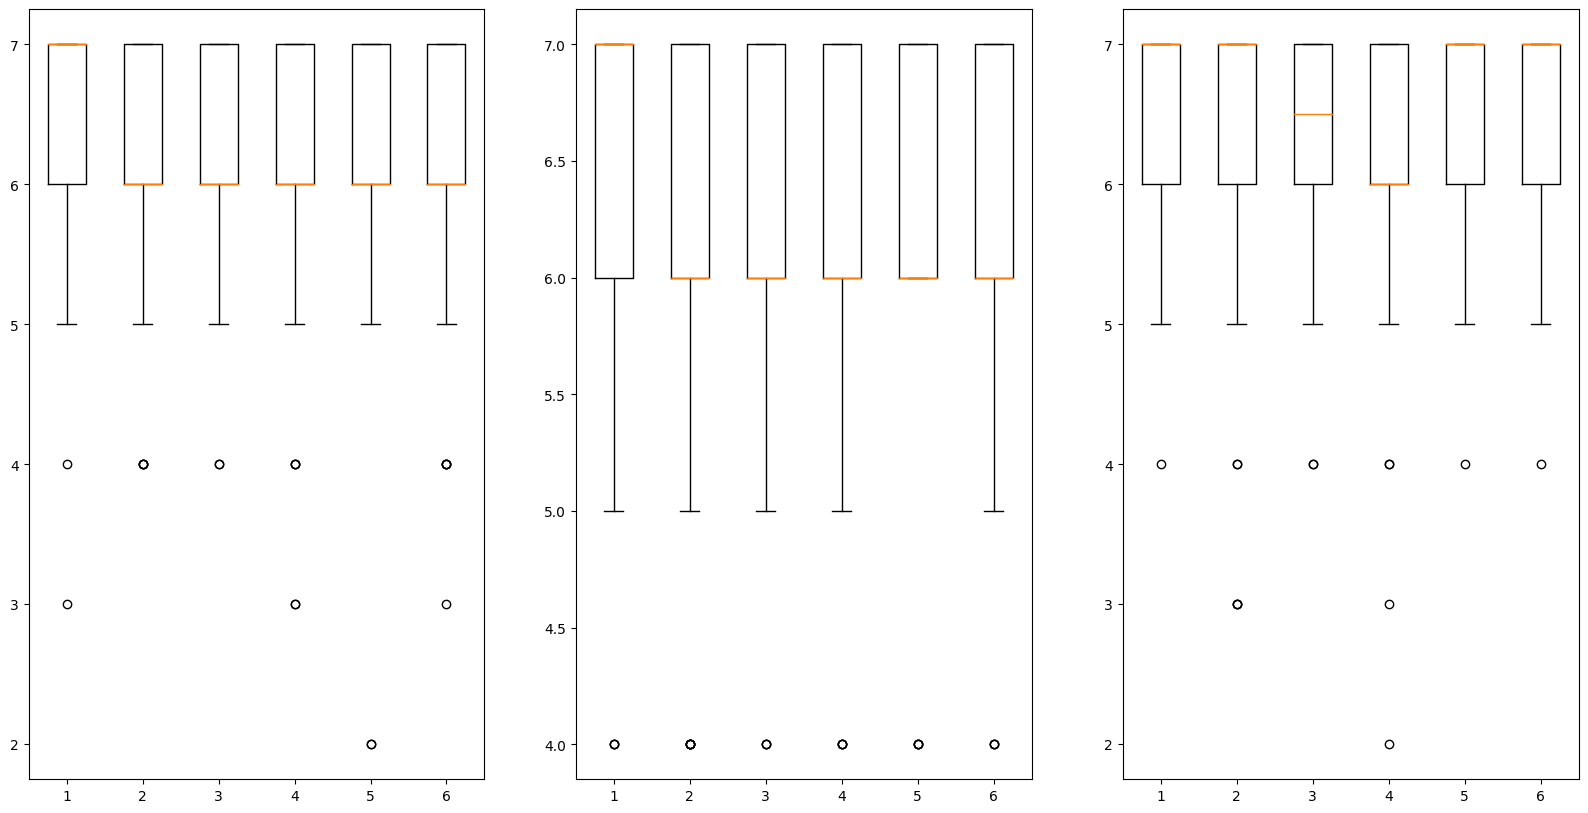

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_1])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_1])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_1])
plt.show()

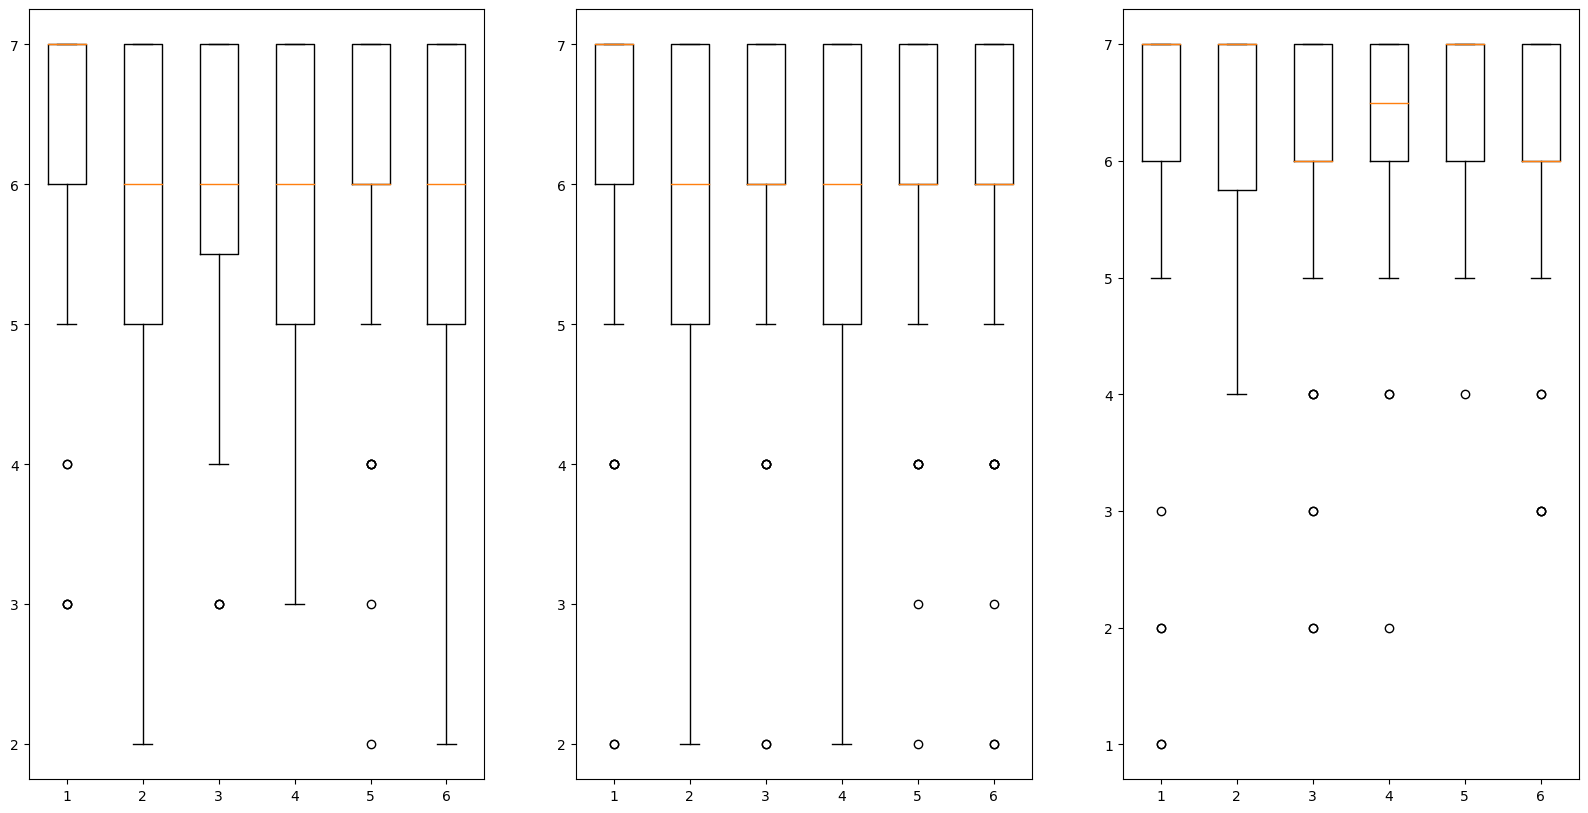

In [54]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_2])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_2])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_2])
plt.show()

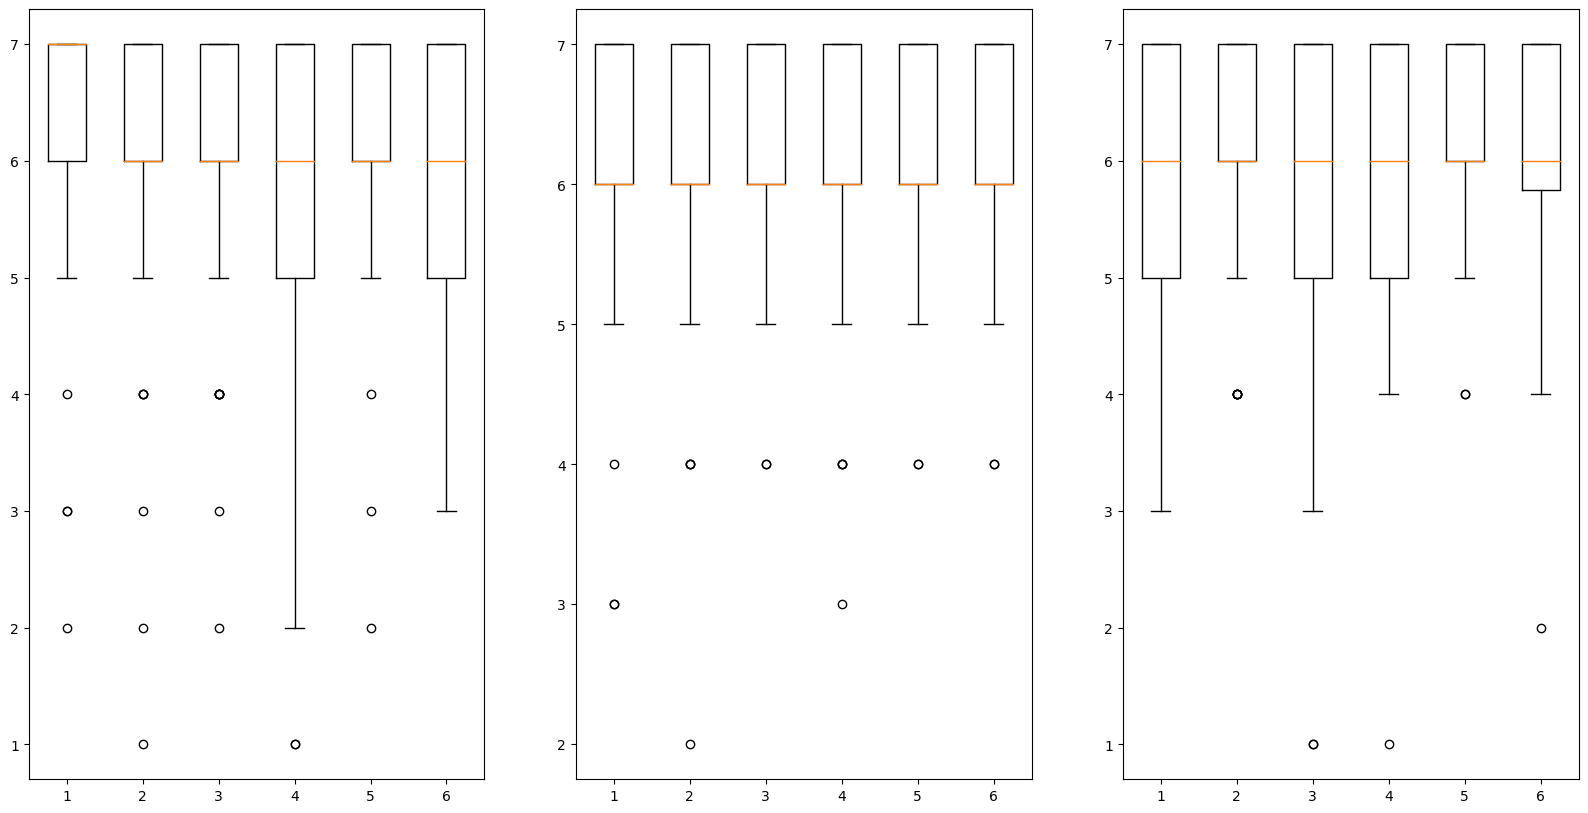

In [55]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_3])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_3])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_3])
plt.show()

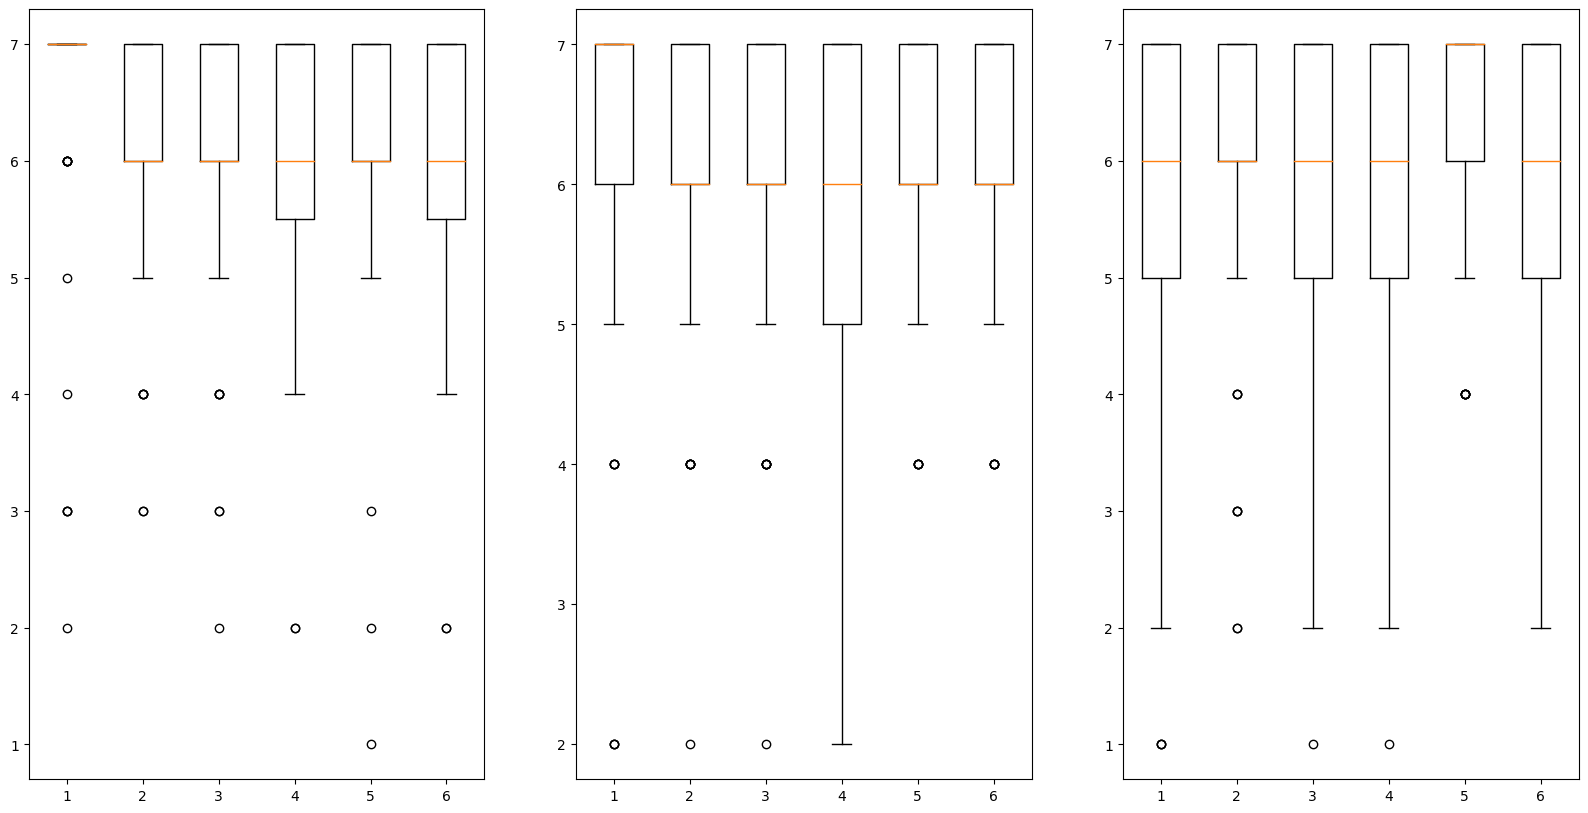

In [56]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_4])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_4])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_4])
plt.show()

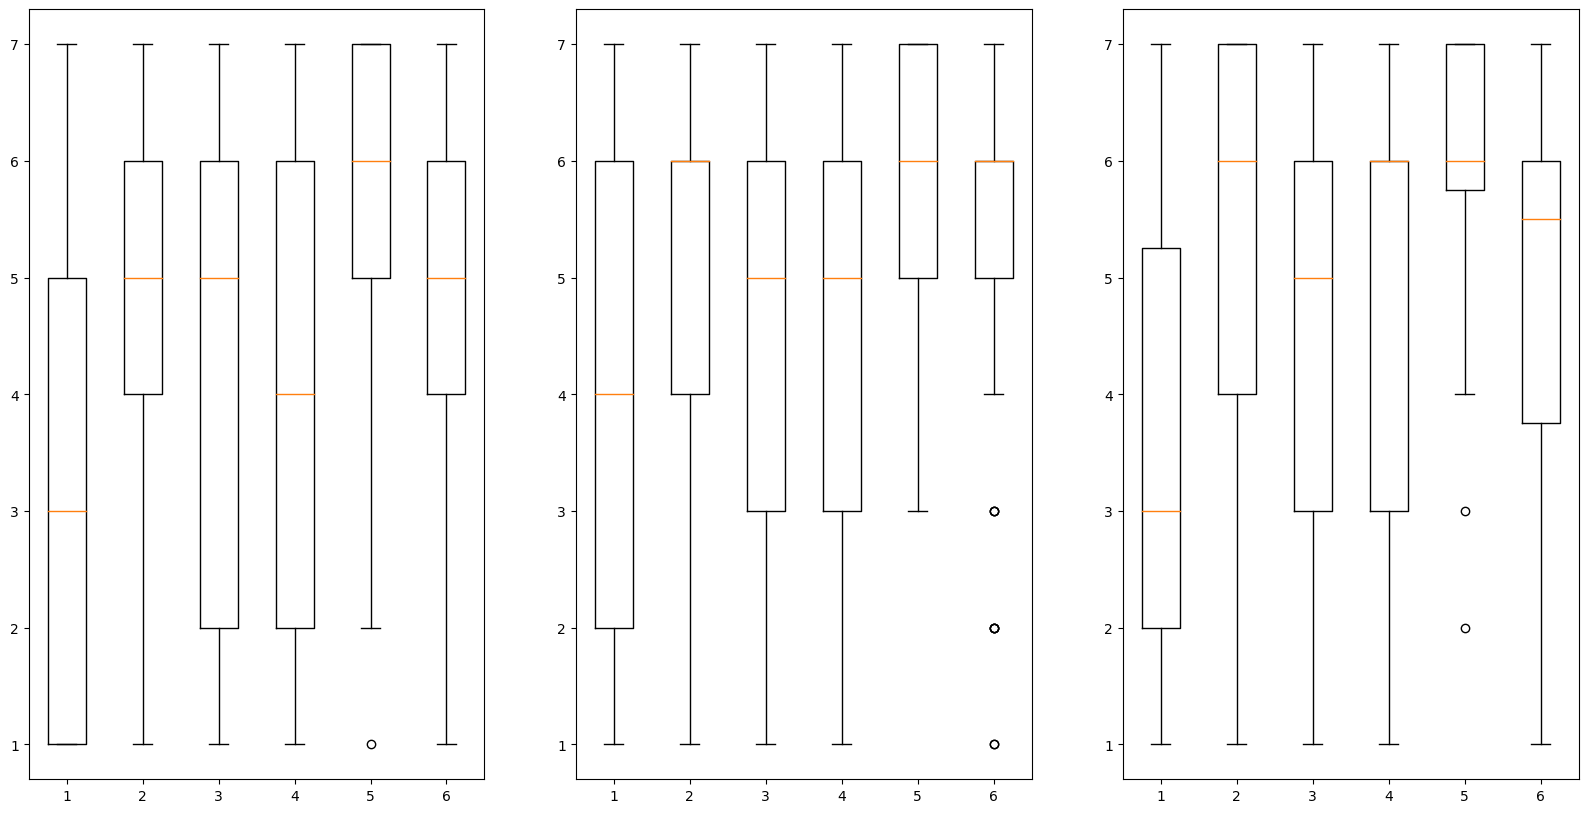

In [57]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_5])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_5])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_5])
plt.show()

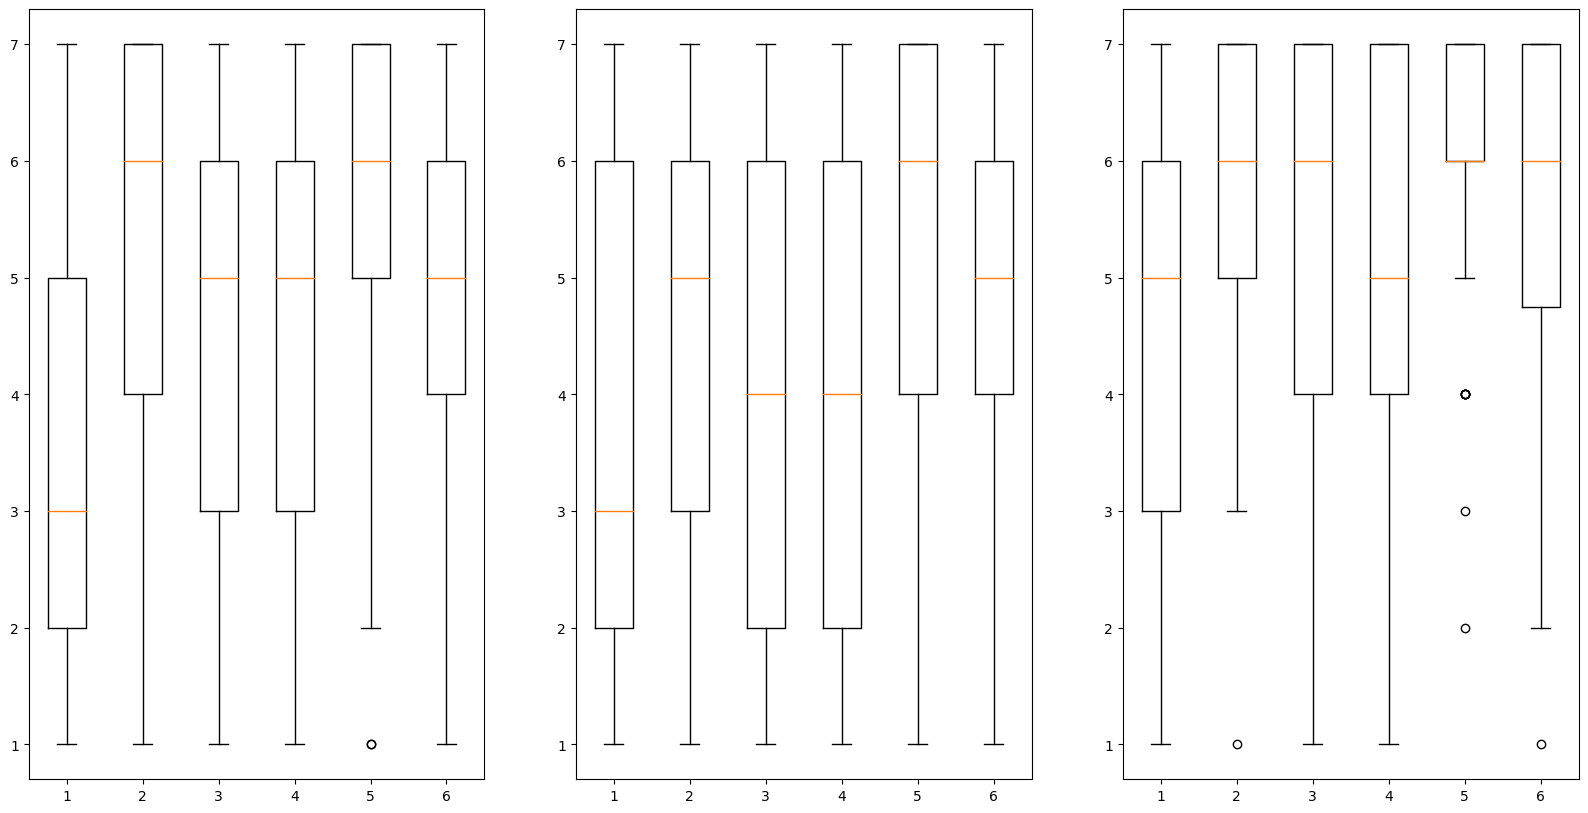

In [58]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.boxplot(basic[sys_eval_6])
plt.subplot(1,3,2)
plt.boxplot(salient[sys_eval_6])
plt.subplot(1,3,3)
plt.boxplot(explanations[sys_eval_6])
plt.show()

## AI System evaluation 

In [59]:
ai_sys_eval_cols = [col for col in df.columns if col.startswith('ai-system-evaluation')]
ai_sys_eval_cols.remove("ai-system-evaluation.additional-functionality")
ai_sys_eval_cols.remove("ai-system-evaluation.most-useful-explanation-feature")
ai_sys_eval_cols.remove("ai-system-evaluation.other-information-wish")
ai_sys_eval_cols.remove("ai-system-evaluation.value-speed-or-comprehensiveness")


ai-system-evaluation.benefit-of-doubt count    160.000000
mean       5.156250
std        1.310561
min        1.000000
25%        5.000000
50%        5.000000
75%        6.000000
max        7.000000
Name: ai-system-evaluation.benefit-of-doubt, dtype: float64


ai-system-evaluation.classification-comprehensible count    160.000000
mean       5.337500
std        1.288007
min        1.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        7.000000
Name: ai-system-evaluation.classification-comprehensible, dtype: float64


ai-system-evaluation.easy-to-follow-what-system-does count    160.000000
mean       5.312500
std        1.379032
min        1.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        7.000000
Name: ai-system-evaluation.easy-to-follow-what-system-does, dtype: float64


ai-system-evaluation.know-what-will-happen-next-time count    160.00000
mean       4.99375
std        1.55202
min        1.00000
25%        4.00000
50%        5.000

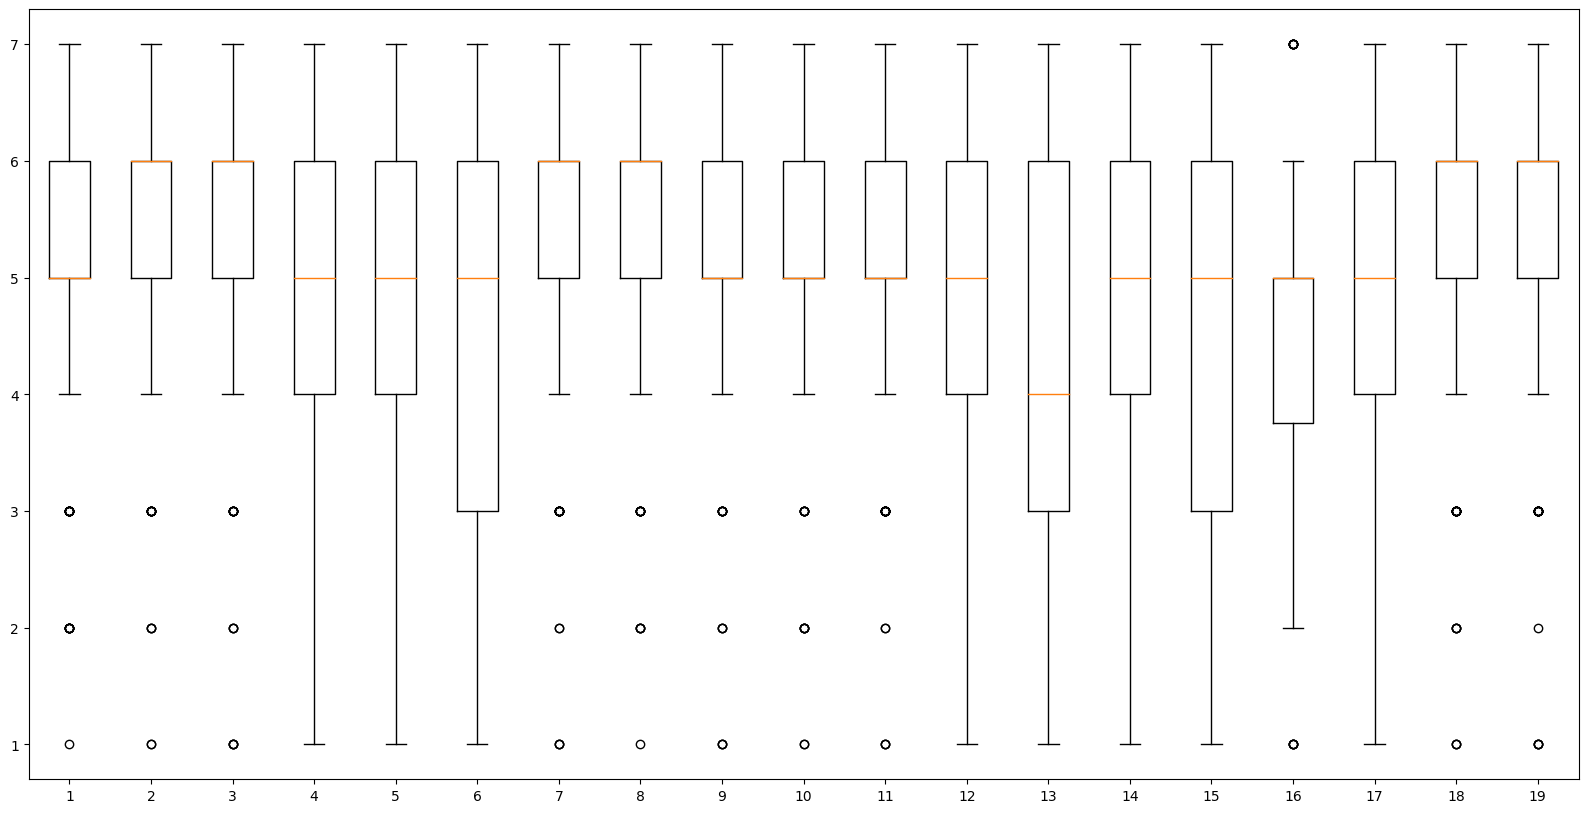

In [60]:


for i, _col in enumerate(ai_sys_eval_cols):
    print(f"{_col}", df[_col].describe())
    
    print('\n')

plt.figure(figsize=(20,10))
plt.boxplot(df[ai_sys_eval_cols])
plt.show()
# # df["ai-system-evaluation.benefit-of-doubt"].plot(kind='box')
# plt.plot() 
# df["ai-system-evaluation.classification-comprehensible"].plot(kind='box')

## Expectations

In [61]:
expectation_cols = [col for col in df.columns if col.startswith('expectations')] 


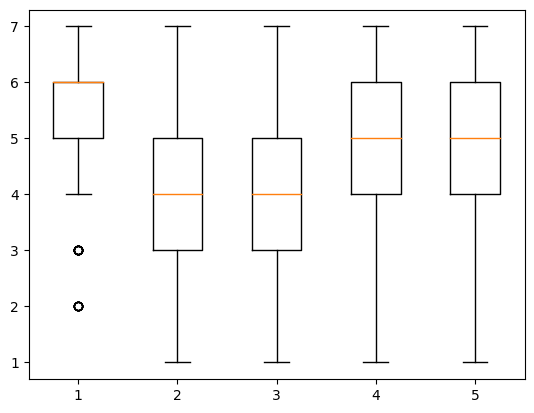

In [62]:
plt.boxplot(df[expectation_cols])
plt.show()

## Information litteracy

In [63]:
info_litteracy_cols = [col for col in df.columns if col.startswith('information-literacy')] 

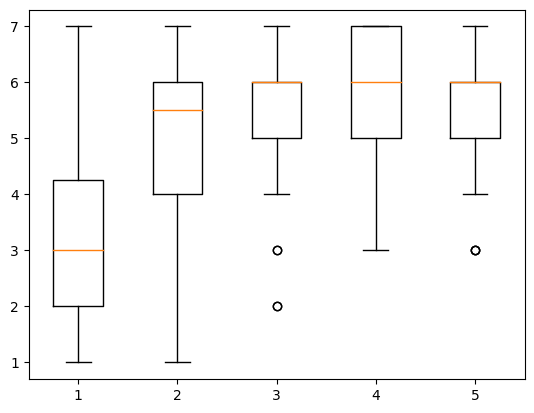

In [64]:
plt.boxplot(df[info_litteracy_cols])
plt.show()

## Correlation between demographics and consciousness

Link to the SCQ-S : https://repository.uantwerpen.be/docman/irua/126198/152149_2020_07_12.pdf

In [65]:
information_seeking_cols = [col for col in df.columns if col.startswith('information-seeking')] 
df[information_seeking_cols]

,information-seeking.sources.A3,information-seeking.sources.A7,information-seeking.sources.A8,information-seeking.sources.B11,information-seeking.sources.B6,information-seeking.sources.B9,information-seeking.sources.K12,information-seeking.sources.K16,information-seeking.sources.K17
0,3,2,7,1,3,4,2,5,6
1,4,5,4,3,3,4,4,5,3
2,6,5,6,6,6,6,6,7,6
3,7,7,6,6,6,4,7,7,7
4,7,7,6,4,6,5,7,6,4
...,...,...,...,...,...,...,...,...,...
155,7,7,5,7,5,5,7,6,6
156,7,6,6,3,6,3,7,5,6
157,7,7,6,7,7,7,7,7,5
158,7,7,7,2,5,5,7,6,6


In [66]:
def scq_score(df) :
    tmp = pd.DataFrame(np.sum([df["information-seeking.sources.A3"]*0.638,
               df["information-seeking.sources.A7"]*0.808,
                 df["information-seeking.sources.A8"]*0.683,
                   df["information-seeking.sources.B11"]*0.670,
                     df["information-seeking.sources.B6"]*0.506,
                     df["information-seeking.sources.B9"]*0.486,
                     df["information-seeking.sources.K12"]*0.514,
                       df["information-seeking.sources.K16"]*0.722,
                         df["information-seeking.sources.K17"]*0.644], axis=0))
    return tmp

In [68]:
print('all : ', scq_score(df).describe())
print('basic : ', scq_score(basic).describe())
print('salient : ', scq_score(salient).describe())
print('exp : ', scq_score(explanations).describe())

all :                  0
count  160.000000
mean    33.378506
std      3.845124
min     20.015000
25%     31.069000
50%     33.990500
75%     36.041000
max     39.697000
basic :                 0
count  51.000000
mean   33.070686
std     3.734029
min    20.945000
25%    31.377000
50%    33.245000
75%    35.135000
max    39.697000
salient :                 0
count  53.000000
mean   33.853604
std     4.054941
min    20.015000
25%    31.447000
50%    34.841000
75%    36.656000
max    39.697000
exp :                 0
count  56.000000
mean   33.209196
std     3.766478
min    24.805000
25%    30.166000
50%    33.982000
75%    35.966250
max    39.697000


In [69]:
age_21_29 =  df[df["demographics.age"] == "21-29"]
age_30_39 =  df[df["demographics.age"] == "30-39"]
age_40_49 =  df[df["demographics.age"] == "40-49"]


In [70]:
print("eco 20", scq_score(age_21_29).describe())
print("eco 30", scq_score(age_30_39).describe())
print("eco 40", scq_score(age_40_49).describe())

eco 20                0
count  33.000000
mean   33.393061
std     3.787925
min    22.394000
25%    31.260000
50%    33.745000
75%    35.229000
max    39.697000
eco 30                0
count  69.000000
mean   33.569464
std     3.861897
min    20.945000
25%    31.386000
50%    33.955000
75%    36.781000
max    39.697000
eco 40                0
count  33.000000
mean   33.522333
std     3.475885
min    24.984000
25%    31.447000
50%    33.805000
75%    36.162000
max    39.697000


In [71]:
male = df[df["demographics.gender"] == "male"]
female = df[df["demographics.gender"] == "female"]

In [72]:
print(scq_score(male).describe())
print(scq_score(female).describe())

               0
count  51.000000
mean   33.387412
std     3.847123
min    24.109000
25%    30.752500
50%    33.745000
75%    36.550500
max    39.697000
                0
count  105.000000
mean    33.309743
std      3.879984
min     20.015000
25%     31.427000
50%     34.026000
75%     35.854000
max     39.697000


In [73]:
df["demographics.income"].unique()

array(['50000-74999-usd', '20000-34999-usd', '35000-49999-usd',
       'over-100000-usd', 'less-than-20000-usd', '75000-99999-usd',
       'no-answer'], dtype=object)

In [74]:
val_50 = df[df['demographics.income'] == '50000-74999-usd'] 
val_20 = df[df['demographics.income'] == '20000-34999-usd']
val_less = df[df['demographics.income'] == 'less-than-20000-usd']
val_35 = df[df['demographics.income'] == '35000-49999-usd']
val_75 = df[df['demographics.income'] == '75000-99999-usd']
val_more = df[df['demographics.income'] == 'over-100000-usd']

In [75]:
print(scq_score(val_less).describe())
print(scq_score(val_20).describe())
print(scq_score(val_35).describe())
print(scq_score(val_50).describe())
print(scq_score(val_75).describe())
print(scq_score(val_more).describe())

               0
count  27.000000
mean   33.178481
std     4.622623
min    20.015000
25%    30.903000
50%    34.553000
75%    35.692000
max    39.697000
               0
count  32.000000
mean   34.120750
std     4.029673
min    22.394000
25%    32.418000
50%    34.946500
75%    37.264250
max    39.211000
               0
count  26.000000
mean   33.106615
std     2.671739
min    28.299000
25%    31.305250
50%    32.924000
75%    34.941000
max    37.765000
               0
count  32.000000
mean   34.137062
std     4.387254
min    20.945000
25%    32.351500
50%    34.368500
75%    37.251750
max    39.697000
               0
count   9.000000
mean   34.822889
std     2.281088
min    31.812000
25%    33.369000
50%    34.327000
75%    35.854000
max    39.697000
               0
count  20.000000
mean   32.093250
std     3.537013
min    24.805000
25%    29.329750
50%    31.940500
75%    34.493250
max    37.726000


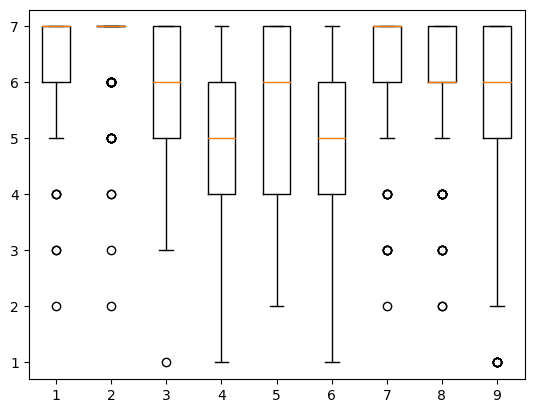

In [76]:
plt.boxplot(df[information_seeking_cols])
plt.show()

In [77]:
df["METADATA.workDurationInMinutes.main"].describe()

count    160.000000
mean      21.526771
std       12.923891
min        2.966667
25%       13.625000
50%       18.850000
75%       26.141667
max       83.633333
Name: METADATA.workDurationInMinutes.main, dtype: float64

In [78]:
test = scipy.stats.kruskal(basic["METADATA.workDurationInMinutes.qualification"],salient["METADATA.workDurationInMinutes.qualification"],explanations["METADATA.workDurationInMinutes.qualification"])
test2 = scipy.stats.kruskal(basic["METADATA.workDurationInSeconds.main"],salient["METADATA.workDurationInSeconds.main"],explanations["METADATA.workDurationInSeconds.main"])

In [79]:
print(test)
print(test2)

KruskalResult(statistic=0.21034506795310648, pvalue=0.9001691994158428)
KruskalResult(statistic=1.2942453994282366, pvalue=0.5235500222689629)


### Time spent to complete the questionnaire and the main part

In [80]:
timeMain = {'All' : df["METADATA.workDurationInMinutes.main"],
                     'Basic' : basic["METADATA.workDurationInMinutes.main"],
                     'Salient' : salient["METADATA.workDurationInMinutes.main"],
                     'Axplanation' : explanations["METADATA.workDurationInMinutes.main"]}

In [81]:
timeQual = {'All' : df["METADATA.workDurationInMinutes.qualification"],
                     'Basic' : basic["METADATA.workDurationInMinutes.qualification"],
                     'Salient' : salient["METADATA.workDurationInMinutes.qualification"],
                     'Axplanation' : explanations["METADATA.workDurationInMinutes.qualification"]}

Text(0.5, 1.0, 'Time needed to complete the main part')

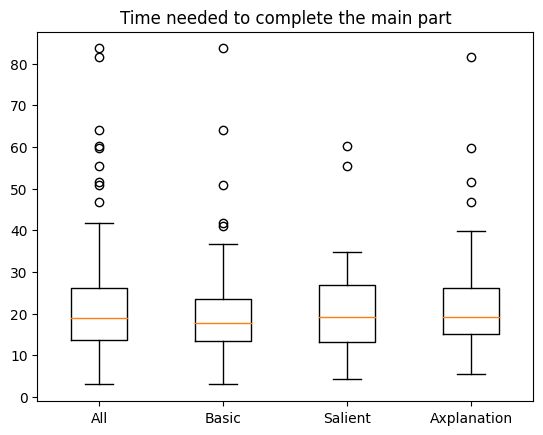

In [82]:
fig, ax= plt.subplots()
ax.boxplot(timeMain.values())
ax.set_xticklabels(timeMain.keys())
ax.set_title("Time needed to complete the main part")



Text(0.5, 1.0, 'Time needed to complete the qualification part')

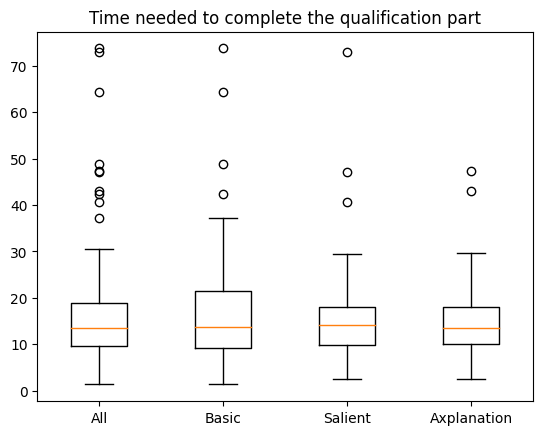

In [83]:
fig, ax= plt.subplots()
ax.boxplot(timeQual.values())
ax.set_xticklabels(timeQual.keys())
ax.set_title("Time needed to complete the qualification part")

## News dashboard evaluation

In [84]:
news_dashboard_cols = [col for col in df.columns if col.startswith('news-dashboard-evaluation')]

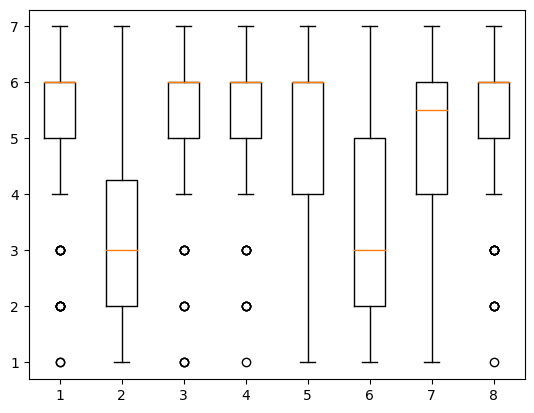

In [85]:
plt.boxplot(df[news_dashboard_cols])
plt.show()